In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load data

In [0]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as pyplot
from skimage.color import rgb2gray
import numpy as np

Using TensorFlow backend.


# define U-Net

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None,input_size = (32,32,1)):
    inputs = Input(input_size)
    print(inputs.shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# define discriminator

In [0]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.utils import plot_model
from keras import callbacks

In [0]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5],metrics=['acc','mae'])
	return model

# define Gans

In [0]:
def define_gan(g_model, d_model, image_shape):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # define the source image
  in_src = Input(shape=(32,32,1))
  in_src2 = Input(shape=(32,32,3))
  # print(in_src.shape)
  # # connect the source image to the generator input
  gen_out = g_model(in_src)
  print(gen_out)
  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src2, gen_out])
  # src image as input, generated image and classification output
  model = Model([in_src, in_src2], [dis_out, gen_out])
  print("in"+str(in_src.shape)+str(in_src2.shape))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100],metrics=['acc','mae'])
  return model

# define gen_real gen_fake summarize

In [0]:
from numpy.random import randint

In [0]:
def generate_real_samples(dataset, n_samples, patch_shape):
  trainA = dataset
  trainB = dataset
  ix = randint(0, trainA.shape[0], n_samples)
  X1, X2 = trainA[ix], trainB[ix]
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

In [0]:
def generate_fake_samples(g_model, samples, patch_shape):

  # set samples to gray
  # samples_gray = rgb2gray(samples)
  # samples_gray = np.array(samples_gray)
  # samples_gray = np.reshape(samples_gray, (1,32,32,1))
  # samples_gray = samples_gray/255.

  X = g_model.predict(samples)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [0]:
def reshape(item, shape):
  item = np.array(item)
  item = np.reshape(item, shape)
  item = item/255.
  return item

In [0]:
def reshape2gray(item, shape):
  item = rgb2gray(item)
  item = np.array(item)
  item = np.reshape(item, shape)
  item = item/255.
  return item

In [0]:
def summarize_performance(step, g_model, dataset, n_samples=3):

  [X_realA, X_realB], _ = generate_real_samples(dataX, n_samples, 1)
  X_realA_gray = reshape2gray(X_realA,(n_samples,32,32,1))
  X_fakeB, _ = generate_fake_samples(g_model, X_realA_gray, 1)

  # plot real
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])

  # plot predicted
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+n_samples+i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])

  # save plot to file
  filename1 = '/content/drive/My Drive/Coding In AI/unet_ch/plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()

  # save the generator model
  filename2 = '/content/drive/My Drive/Coding In AI/unet_ch/model_%06d.hdf5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

# define gan training

In [0]:
def train(d_model, g_model, gan_model, dataset, n_epochs=5, n_batch=1):
  n_patch = d_model.output_shape[1]
  trainA = dataset
  bat_per_epo = int(len(trainA) / n_batch)
  n_steps = bat_per_epo * n_epochs

  # trainA = np.array(trainA)
  # trainA = np.reshape(trainA, (50,32,32,3))
  # trainA = trainA/255.

  trainA = reshape(trainA, (50000,32,32,3))

  for i in range(n_steps):
    [X_realA, X_realB], y_real = generate_real_samples(trainA, n_batch, n_patch)
    X_realA_gray = reshape2gray(X_realA,(1,32,32,1))
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA_gray, n_patch)

    # X_realA = np.array(X_realA)
    # X_realA = np.reshape(X_realA, (1,32,32,3))
    # X_realA = X_realA/255.

    # X_realB = np.array(X_realB)
    # X_realB = np.reshape(X_realB, (1,32,32,3))
    # X_realB = X_realB/255.

    # X_realA_gray = rgb2gray(X_realA)
    # X_realA_gray = np.array(X_realA_gray)
    # X_realA_gray = np.reshape(X_realA_gray, (1,32,32,1))
    # X_realA_gray = X_realA_gray/255.

    d_loss1, _, _ = d_model.train_on_batch([X_realA, X_realB], y_real)
    d_loss2, _, _ = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    g_loss = gan_model.train_on_batch([X_realA_gray, X_realA], [y_real,X_realB])
    
    if i%1000 == 0:
      print('>%d' % (i+1))
    if ((i+1) % (bat_per_epo * 1)) == 0:
      summarize_performance(((i%50000)+12),g_model, trainA)

# Build Generator, Discriminator, GANs models

In [0]:
from sklearn.model_selection import train_test_split
(dataX, _), (_, _) = load_data()
# (tempX, tempY), (_, _) = load_data()
# dataX, _, _,_ = train_test_split(tempX, tempY, test_size=0.99, random_state=42)

image_shape = (32,32,3)
d_model = define_discriminator(image_shape)
g_model = unet()
gan_model = define_gan(g_model, d_model, image_shape)

170500096/170498071 [==============================] - 11s 0us/step













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(?, 32, 32, 1)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Tensor("model_2/conv2d_30/Sigmoid:0", shape=(?, 32, 32, 3), dtype=float32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


in(?, 32, 32, 1)(?, 32, 32, 3)


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 32, 32, 3)    31049091    input_9[0][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 (None, 2, 2, 1)      6968257     input_10[0][0]                   
                                                                 model_5[1][0]              

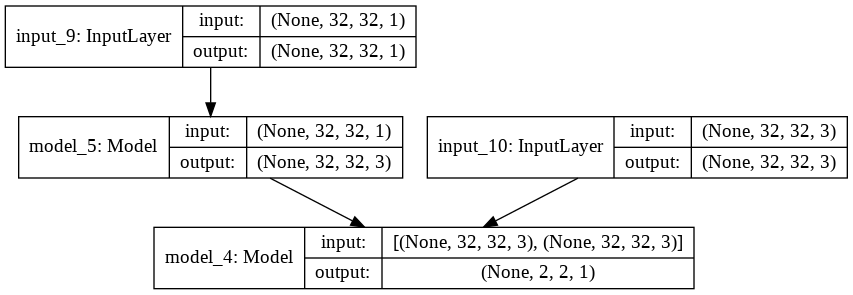

In [0]:
gan_model.summary()
plot_model(gan_model, to_file='gan.png', show_shapes=True)

# Train GANs

In [0]:
g_model.load_weights('/content/drive/My Drive/Coding In AI/unet_ch/model_000015.hdf5')

In [0]:
train(d_model, g_model, gan_model, dataX,)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1
>1001
>2001
>3001
>4001
>5001
>6001
>7001
>8001
>9001
>10001
>11001
>12001
>13001
>14001
>15001
>16001
>17001
>18001
>19001
>20001
>21001
>22001
>23001
>24001
>25001
>26001
>27001
>28001
>29001
>30001
>31001
>32001
>33001
>34001
>35001
>36001
>37001
>38001
>39001
>40001
>41001
>42001
>43001
>44001
>45001
>46001
>47001
>48001
>49001
>Saved: /content/drive/My Drive/Coding In AI/unet_ch/plot_050012.png and /content/drive/My Drive/Coding In AI/unet_ch/model_050012.hdf5
>50001
>51001
>52001
>53001
>54001
>55001
>56001
>57001
>58001
>59001
>60001
>61001
>62001
>63001
>64001
>65001
>66001
>67001
>68001
>69001
>70001
>71001
>72001
>73001
>74001
>75001
>76001
>77001
>78001
>79001
>80001
>81001
>82001
>83001
>84001
>85001
>86001
>87001
>88001
>89001
>90001
>91001
>92001
>93001
>94001
>95001
>96001
>97001
>98001
>99001
>Saved: /content/drive/My Drive/Coding In AI/unet_ch/plot_050012.png and /content/drive/My Drive/Coding In AI/unet_ch/model_050012.hdf5
>100001
>101001
>102001
>103001
>104001
>

KeyboardInterrupt: ignored

# Evaluate

In [0]:
(data, _), (_,_) = load_data()
X = rgb2gray(data)
X = np.array(X)
X = np.reshape(X,(50000,32,32,1))
X = X/255.

Y = np.array(data)
Y = np.reshape(Y,(50000,32,32,3))
Y = Y/255.
loss,acc = g_model.evaluate(X,Y)

50000/50000 [==============================] - 21s 420us/step


In [0]:
print('loss'+ str(loss) + ',acc' + str(acc))

loss0.5599590446853637,acc0.012059935185573994


# Predice GANs

In [0]:
(_, _), (label_test,_) = load_data()
original_gray = rgb2gray(label_test)
testX = np.array(original_gray)
testX = np.reshape(testX, (10000,32,32,1))
print(testX.shape)
testX = testX/255.
result = g_model.predict(testX)

(10000, 32, 32, 1)


(10000, 32, 32, 3)
(10000, 32, 32)
(10000, 32, 32, 3)


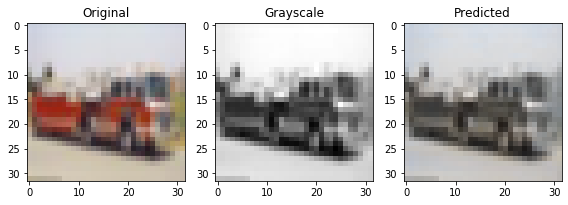

In [0]:
# Show result
item = 8000
#8000
print(label_test.shape)
print(original_gray.shape)
print(result.shape)
fig, axes = pyplot.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(label_test[item])
ax[0].set_title("Original")
ax[1].imshow(original_gray[item], cmap=pyplot.cm.gray)
ax[1].set_title("Grayscale")
ax[2].imshow(result[item])
ax[2].set_title("Predicted")

fig.tight_layout()
pyplot.show()